# Sequence design for RNA-RNA interactions

The design of RNA sequences with desired structural properties presents
a challenging computational problem with promising applications in biotechnology
and biomedicine. Most regulatory RNAs function by forming RNA-RNA interactions,
e.g., in order to regulate mRNA expression. It is therefore natural to consider
problems where a sequence is designed to form a desired RNA-RNA interaction and
switch between structures upon binding. This contribution demonstrates the use of
the Infrared framework to design interacting sequences. Specifically, we consider
the regulation of the rpoS mRNA by the sRNA DsrA and design artificial 5’UTRs
that place a downstream protein coding gene under control of DsrA.

### Setup

In [1]:
import random
import math
from PIL import Image
import time

# Third party package
import RNA
import infrared
## We need to implicit import infrared.rna for version <= 1.2
import infrared.rna
## Script for this project
import rri

# The DsrA-rpoS regulation example
The sRNA DsrA is known to regulating the translation of RpoS by binding to the 5'UTR of rpoS mRNA and therby inducing a change in the mRNA structure, making the ribosome binding side(RBS) accessible.

## Native DsrA structure 

DsrA on its addopts a conformation with three stem-loop (SL) structures. The first(SL1) and (SL3) are predicted and experimentally confirmed to be stable and unique while the region of the SL2 is thought to have multiple alternative folds. 

In [2]:
# DsrA from e.coli; NC_000913.3(2025313-2025225)
dsra_seq     = "AACACAUCAGAUUUCCUGGUGUAACGAAUUUUUUAAGUGCUUCUUGCUUAAGCAAGUUUCAUCCCGACCCCCUCAGGGUCGGGAUUUUU"
dsra_str     = '...(((((((.....)))))))...(((((((((((((.......))))))).)))))).((((((((((.....))))))))))....'
dsra_str_alt = "...(((((((.....)))))))....................(((((....)))))....((((((((((.....))))))))))...."
dsra_str_min = '...(((((((.....)))))))......................................((((((((((.....))))))))))....'
dsra_inter   = ".........((((((((..(((((((((((((..((((((................................................."
dsra_len = len(dsra_seq)

## Native rpoS structure 
The rpoS mRNA is poorly transcribed, since the ribosome binding site is sequestered in a stable secondary structure. We define the ribosome binding site as a 30nt region starting at the Shine-Dalgarno motif (AGGAGC in the rpoS mRNA).




In [3]:
# rpoS 5'UTR fragment (TSS -150nts +27nts):  NC_000913.3(2867701-2867525)
             #....,....1....,....2....,....3....,....4....,....5....,....6....,....7....,....8....,....9....,....0....,....1....,....2....,....3....,....4....,....5....,....6....,....7....,....8....,....9....,....0
             #NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNaggagcNNNNNNaugagNNNNNNNNNNNNNNNNNNNNNN
rpos_seq =   "CACCGGAACCAGUUCAACACGCUUGCAUUUUGAAAUUCGUUACAAGGGGAAAUCCGUAAACCCGCUGCGUUAUUUGCCGCAGCGAUAAAUCGGCGGAACCAGGCUUUUGCUUGAAUGUUCCGUCAAGGGAUCACGGGUAGGAGCCACCUUAUGAGUCAGAAUACGCUGAAAGUUCAU"
rpoS_inter = "........................)))))).)))))))))))))..))))))))..........................................................................................................................."
rpos_str   = "...................................(((((...((((((..((((((...(((...............................................................)))...)))))).....)).)))))))))......................"
rpos_len = len(rpos_seq)

# set some rpos specific parameters
rri.PARAMS['SD_pos'] = rpos_seq.find(rri.PARAMS['SD'])+1  # ViennaRNA uses 1-based coords
rri.PARAMS['AUG_pos'] = rpos_seq.find('AUGAG')+1

# set some structure prediction parameters
## setting the maximum base pair span at least ~20nts below the mRNA length avoids artifacts
## originating from the fact that the 3' end of mRNA fragment is not the actual end of the RNA sequence
rri.PARAMS['BP_SPAN'] = 200

print(rri.PARAMS)

{'SD': 'AGGAGC', 'SD_pos': 139, 'AUG_pos': 151, 'BP_SPAN': 200}


## Plots of the predicted mfe structure of DsrA and the rpoS 5'UTR before binding

Predict secondary structures of undbound RNAs

In [4]:
# UnBound
rpos_unbound, dsra_unbound = rri.prediction_unbound(rpos_seq, dsra_seq)
print(rpos_seq)
print(rpos_unbound)
print(dsra_seq)
print(dsra_unbound)

CACCGGAACCAGUUCAACACGCUUGCAUUUUGAAAUUCGUUACAAGGGGAAAUCCGUAAACCCGCUGCGUUAUUUGCCGCAGCGAUAAAUCGGCGGAACCAGGCUUUUGCUUGAAUGUUCCGUCAAGGGAUCACGGGUAGGAGCCACCUUAUGAGUCAGAAUACGCUGAAAGUUCAU
.....((((...((((....((....(((((((..(((((...((((((..((((((...(((((((((........))))))........(((((((((((((....)))))...))))))))..)))...)))))).....)).))))))))))))))))..)))))).))))..
AACACAUCAGAUUUCCUGGUGUAACGAAUUUUUUAAGUGCUUCUUGCUUAAGCAAGUUUCAUCCCGACCCCCUCAGGGUCGGGAUUUUU
...(((((((.....)))))))...(((((((((((((.......))))))).)))))).((((((((((.....))))))))))....


Get secondary structure plot

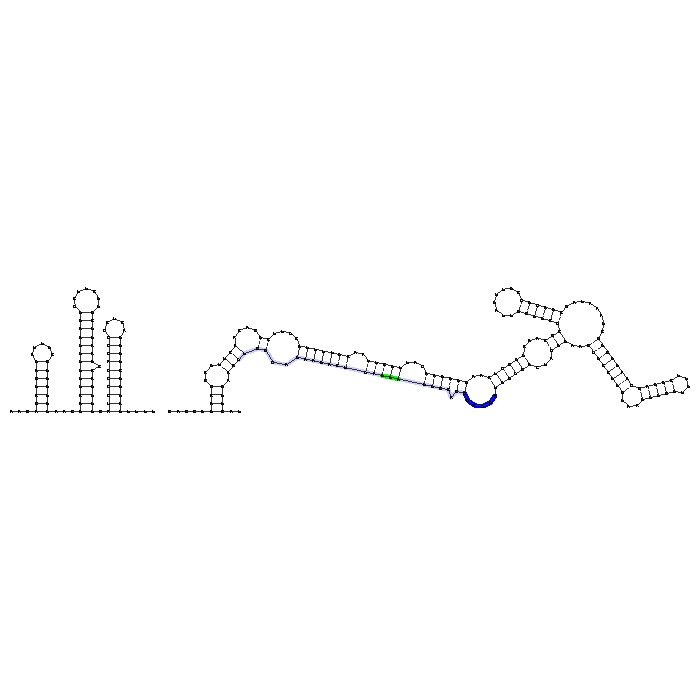

In [5]:
from PIL import Image

rri.draw_RNAplot(
    dsra_seq,
    rpos_seq,
    dsra_unbound,
    rpos_unbound,
    SD_pos=rri.PARAMS["SD_pos"],
    SD_len=6,
    AUG_pos=rri.PARAMS["AUG_pos"],
    output="unbound_DsrA_rpoS.ps",
)

## Accessibility of the RBS in the unbound rpoS

Let's compute the opening energy of the ribosome binding withnout sRNA

In [6]:
# Free-energy required to open the region of 30nts from Shine-Dalgarno motif at unbound rpos
print('{:6.2f} kcal/mol'.format(rri.dGopen(rpos_seq, (rri.PARAMS['SD_pos'], rri.PARAMS['SD_pos']+29))))

 11.23 kcal/mol


## The DsrA - rpoS interaction 
Next, we compute the opening energy after binding of dsRNA

To this end, we first predict the interaction using RNAup

In [7]:
# Bound region computed using RNAup and binding energy
i, j, k, l, be = rri.RNAup(rpos_seq, dsra_seq)
print("Binding region of rpos:", (i, j))
print("Binding region of rdsa:", (k, l))
print("Binding Energy:", be, "kcal/mol")

Binding region of rpos: (25, 54)
Binding region of rdsa: (10, 40)
Binding Energy: -11.93 kcal/mol


Next, we compute and drawing of the resulting DsrA-rpoS complex. For simplicity we do not show DsrA structure, except for the inter-molecular base pairs:

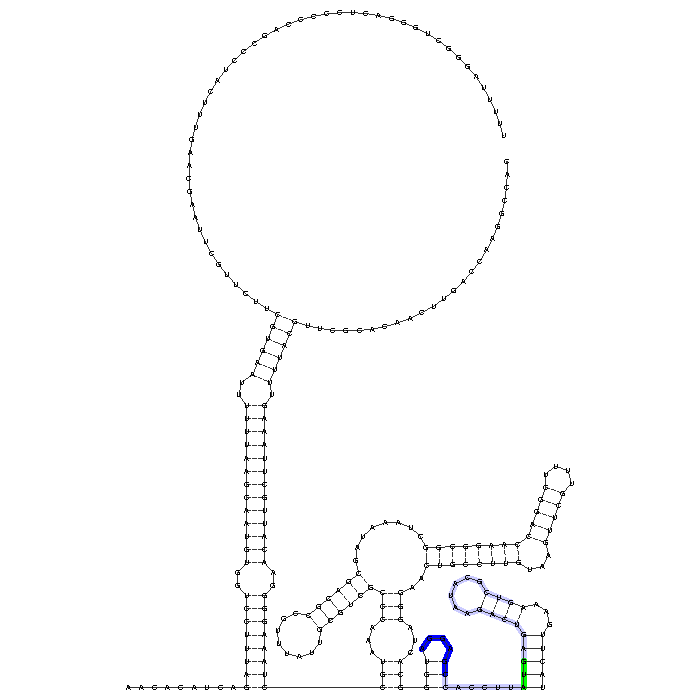

In [8]:
# Bound
rpos_bound, dsra_bound = rri.prediction_bound(rpos_seq, dsra_seq)
rri.draw_RNAplot(dsra_seq, rpos_seq, dsra_bound, rpos_bound, output='bound_DsrA_rpoS.ps')

We can also compute the energylandscape and kinetic features of the interaction with RRIkinDP (https://github.com/mwaldl/RRIkinDP/tree/dev).

- free energy of the full interaction with RRIkinDP: -11.69kcal/mol
- free energy of the barrier state: 0.68kcal/mol
- free energy of 5bps seed from which the minimum barrier folding paths starts: 0.68kcal/mol
- seed resulting in the minimum barrier state folding path starts at base pair 12
The interaction range on the sRNA is 10-40
The interaction range on the mRNA is 25-54
Base pair list: (10,54):(11,53):(12,52):(13,51):(14,50):(15,49):(16,48):(17,47):(20,44):(21,43):(22,42):(23,41):(24,40):(25,39):(26,38):(27,37):(28,36):(29,35):(30,34):(31,33):(32,32):(35,30):(36,29):(37,28):(38,27):(39,26):(40,25)
interaction in db notation: .........((((((((..(((((((((((((..((((((.................................................&........................)))))).)))))))))))))..))))))))...........................................................................................................................
E: -11.39, ED1: 9.22, ED2: 12.09, E_loops: -34.9


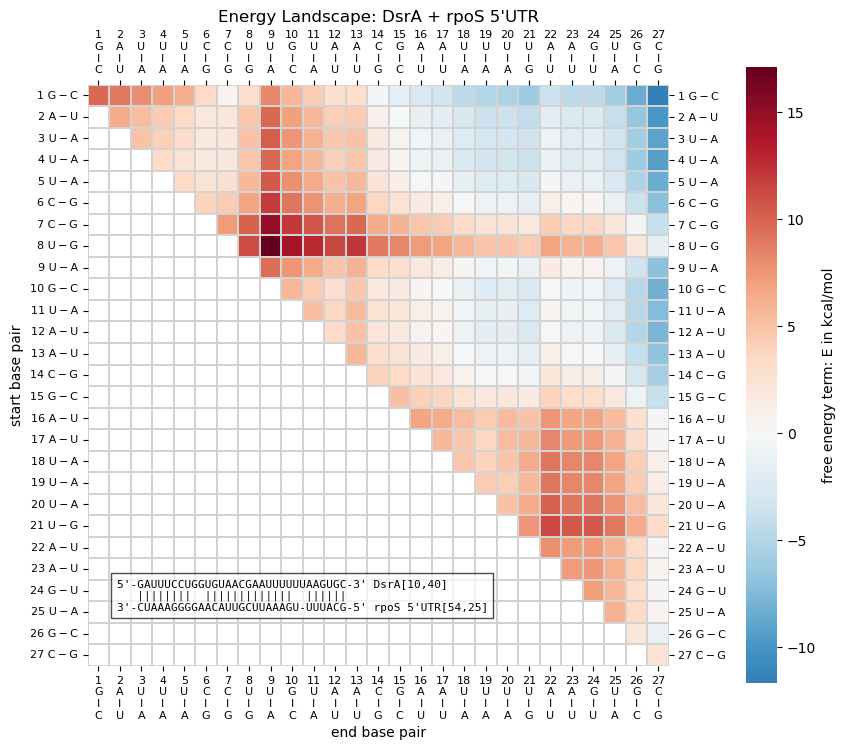

In [9]:
rri.plot_energylandscape(dsra_seq, rpos_seq, id1='DsrA', id2="rpoS 5'UTR", figure_path="natural_kinetic_landscape.pdf", verbose=True)

## Accessibility of the RBS in the bound rpoS

Plus next we calculate the RBS opening energy under the constraint that the region bound by the sRNA cannot form intra-molecular interactions:

In [10]:
# Free-energy required to open the region of 30nts from Shine-Dalgarno motif at bound rpos
print('{:6.2f} kcal/mol'.format(rri.dGopen(rpos_seq, (rri.PARAMS['SD_pos'], rri.PARAMS['SD_pos']+29), constraint=(i, j))))

  6.34 kcal/mol


# The design

We're now ready to design novel mRNAs that are controlled by DsrA, similar to rpoS. First we need to setup the sequence and structure constraints.


### Sequence constraint
In our example we assume GFP as the target protein. Below we enter the first exonsof GFP (GenBank: M62654.1  208 to 413) ) and select the first 9 codons (27 nts) as input coding sequence that follows after the designed 5'UTR:

In [11]:
gfp_cds = 'AUGAGUAAAGGAGAAGAACUUUUCACUGGAGUUGUCCCAAUUCUUGUUGAAUUAGAUGGUGAUGUUAAUGGGCACAAAUUCUCUGUCAGUGGAGAGGGUGAAGGUGAUGCAACAUACGGAAAACUUACCCUUAAAUUUAUUUGCACUACUGGAAAGCUACCUGUUCCAUGGCCAACACUUGUCACUACUUUCUCUUAUGGUGUUCA'
print(f'length of input cds: {len(gfp_cds)}')

len_cds_C = 27
cds = gfp_cds[:len_cds_C]

print(f'sequence constraint based on the first {len_cds_C}nts of the targeted cds: {cds}')



length of input cds: 206
sequence constraint based on the first 27nts of the targeted cds: AUGAGUAAAGGAGAAGAACUUUUCACU



Following the DsrA-rpoS example, our designs consists of 150 nt upstream of the AUG start codon. We include the sequence (AGGAGC) and position of the rpoS Shine-Delarno motif. 

In [12]:
sd_pos = rri.PARAMS['SD_pos'] - 1
sd_motif = rri.PARAMS['SD']
print(f'start of the SD motive: {sd_pos}, SD motive: {sd_motif}')

preAUG = ['N'] * 150
preAUG[138:144] = 'AGGAGC'
preAUG = ''.join(preAUG)
print("5'UTR constraint")
print(preAUG)

start of the SD motive: 138, SD motive: AGGAGC
5'UTR constraint
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAGGAGCNNNNNN


To represent the full design we need to merge the fixed DsrA sequence, the 5'UTR and the start of the coding sequence:

In [13]:
sequence_C  = dsra_seq + preAUG + cds

### Structure constraint

Infrared can extract structure contraints from dot braket strings and enforces compatible nucleotides for pairing positions. Each sonstraint string has the length of the full design (DsrA + 150nts UTR + 27nts CDS). 
We set up constraints for the DsrA structure (sRNA_str_C), the helix in the rpoS UTR that makes the RBS unaccessible (mRNA_str_C) the interaction base pairs between DsrA and the rpoS UTR (inter_str_C).

In [14]:
sRNA_str_C  = dsra_str_min + "." * (len(sequence_C) - dsra_len)
mRNA_str_C  = '.' * dsra_len + rpos_str                   
inter_str_C = dsra_inter + rpoS_inter

### Print constraints

In [15]:
print(sequence_C)
print(sRNA_str_C)
print(mRNA_str_C)
print(inter_str_C)

AACACAUCAGAUUUCCUGGUGUAACGAAUUUUUUAAGUGCUUCUUGCUUAAGCAAGUUUCAUCCCGACCCCCUCAGGGUCGGGAUUUUUNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAGGAGCNNNNNNAUGAGUAAAGGAGAAGAACUUUUCACU
...(((((((.....)))))))......................................((((((((((.....)))))))))).....................................................................................................................................................................................
............................................................................................................................(((((...((((((..((((((...(((...............................................................)))...)))))).....)).)))))))))......................
.........((((((((..(((((((((((((..((((((.........................................................................)))))).)))))))))))))..))))))))........................................................

## Infrared model



In [16]:
# RRI general Model factory
def design_model(seq_IUPAC, sRNA_str, mRNA_str, inter_str, split_rna):
    """Infrared model factory for general RRI project

    Args:
        seq_IUPAC: sequence constraints in IUPAC format. The sequence is the concatenation of small RNA and mRNA sequences, e.g. dsra+rpos
        sRNA_str: structure constraints for the sRNA
        mRNA_str: structure constraints for the mRNA
        inter_str: structure constraints for the for the interaction region
        split_rna: function to split sequence into sRNA and mRNA
    """
    # Initial model with sequence length and alphabet size
    n = len(seq_IUPAC)
    model = infrared.Model(n, 4)
    # Set each variable domain w.r.t given sequence constraint
    for i, x in enumerate(seq_IUPAC):
        model.add_constraints(infrared.ValueIn(i, infrared.rna.iupacvalues(x.upper())))

    # function for controlling GC content, negative weight to avoid too high GC
    # model.add_functions([infrared.rna.GCCont(i) for i in subset], 'gc')
    # model.set_feature_weight(-0.3, 'gc')

    # Add structure constraint and Basepair energy
    for name, ss in [("S", sRNA_str), ("M", mRNA_str), ("I", inter_str)]:
        bps = infrared.rna.parse(ss)
        model.add_constraints(infrared.rna.BPComp(i, j) for (i, j) in bps)
        model.add_functions(
            [infrared.rna.BPEnergy(i, j, (i - 1, j + 1) not in bps) for (i, j) in bps],
            f"energy{name}",
        )
        # If one wants to control initial sequence energy
        model.add_feature(
            f"Energy{name}",
            f"energy{name}",
            lambda sample, ss=ss: RNA.energy_of_struct(
                infrared.rna.ass_to_seq(sample), ss
            ),
        )

    # Trick to get positions that should be considered to resample during optimization
    fixed = [i for i in range(n) if seq_IUPAC[i].upper() in "ACGU"]
    # Get all connected components
    ccs = model.connected_components()
    # Keep cc if any of variable value is not fixed
    model.my_connected_components = [
        cc for cc in ccs if any(x not in fixed for x in cc)
    ]
    model.input_str = {"sRNA": sRNA_str, "mRNA": mRNA_str, "inter": inter_str}
    model.ass_to_rna = lambda t: split_rna(infrared.rna.ass_to_seq(t))
    return model

In [17]:
model_rri = design_model(sequence_C, sRNA_str_C, mRNA_str_C, inter_str_C, lambda t: (t[:dsra_len], t[dsra_len:]))

## Optimizations

In [18]:

# Optimizer with simple resampling adapted from Infrared Bookchapter
def mc_optimize(model, cost, steps=1000, temp=0.01, sample=None, verbose=False):
    sampler = infrared.Sampler(model)

    cur = sampler.sample() if sample is None else sample()
    curval = cost(*model.ass_to_rna(cur), verbose=False)

    best, bestval = cur, curval
    if verbose:
        print(model.ass_to_rna(best)[1], bestval)
    cur_step = 0
    while cur_step < steps:
        # In a more complicate case, one should sample cc with weight as cc size
        # but we can ignore in here as all cc sizes are small
        cc = random.choice(model.my_connected_components)
        new = sampler.resample(cc, cur)
        # resample till new assignment is different
        while new.values() == cur.values():
            cc = random.choice(model.my_connected_components)
            new = sampler.resample(cc, cur)
        cur_step += 1
        newval = cost(*model.ass_to_rna(new), verbose=False)
        # print(*model.ass_to_rna(cur), curval)
        if newval - curval > 50 * temp:
            continue
        # print(infrared.rna.ass_to_seq(cur), curval, newval-curval, temp)
        if newval <= curval or random.random() <= math.exp((curval - newval) / temp):
            cur, curval = new, newval
            if curval < bestval:
                best, bestval = cur, curval
                if verbose:
                    print(model.ass_to_rna(best)[1], bestval)
    return (best, bestval)


# Simulated annealing instead of constant temperature MC
def sa_optimize(model, cost, steps=500, temp=1, t_min=1e-6, sample=None, verbose=False):
    assert temp >= t_min
    cool = math.pow(t_min / temp, 1 / steps)
    sampler = infrared.Sampler(model)

    cur = sampler.sample() if sample is None else sample()
    curval = cost(*model.ass_to_rna(cur), verbose=False)

    best, bestval = cur, curval
    if verbose:
        print(*model.ass_to_rna(best), bestval)
    cur_step = 0
    while cur_step < steps:
        cc = random.choice(model.my_connected_components)
        new = sampler.resample(cc, cur)
        # resample till new assignment is different
        while new.values() == cur.values():
            cc = random.choice(model.my_connected_components)
            new = sampler.resample(cc, cur)
        cur_step += 1
        newval = cost(*model.ass_to_rna(new), verbose=verbose)
        if newval - curval > 50 * temp:
            continue
        # print(infrared.rna.ass_to_seq(cur), curval, newval-curval, temp)
        if newval <= curval or random.random() <= math.exp((curval - newval) / temp):
            cur, curval = new, newval
            if curval < bestval:
                best, bestval = cur, curval
                if verbose:
                    print(*model.ass_to_rna(best), bestval)
        # temp = max(temp * cool, 1e-6)
    return (best, bestval)

In [19]:

# Multiple optimization runs for RRI design
# With option of targeted sampling
def run_optimize(
    run, model, cost, optimize=sa_optimize, EI=-30, EM=-15, verbose=False, **kwargs
):
    """Multiple calls of optimize

    Args:
        run (int): number of calls
        model: infrared model (should contain member variable my_connected_components, see design_model_basic)
        cost: cost function
        EI: target energy for interaction region of seed sequence
        ER: target energy for rpos structure of seed sequence
        verbose (bool): enable verbose mode
        kwargs: keyword arguments passed to optimization
    """
    sampler = infrared.Sampler(model)
    sample = sampler.sample
    if EI is not None:
        sampler.set_target(EI, 4, "EnergyI")
        sample = sampler.targeted_sample
    if EM is not None:
        sampler.set_target(EM, 4, "EnergyM")
        sample = sampler.targeted_sample
    for ind in range(run):
        best, bestval = optimize(model, cost, sample=sample, verbose=verbose, **kwargs)
        sRNA, mRNA = model.ass_to_rna(best)
    return sRNA, mRNA, bestval


## Thermodynamic cost function

Here is a first cost function. Our function consists of 4 terms:
- The free energy of binding between sRNA and mRNA (preAUG region)
- The RBS opening energy, with and without sRNA
- The difference between the two openening energies

In order to ensure that the optimization procedure will optimize **all** terms, rather than focusing only on the easiest aspect, we define a target value for each term and use a `LogSumExp` (LSE) as a smooth maximimum function.
This ensures that, if one of the terms becomes significantly better than the target value, further opimizing this term has negligible effect on the overall cost.




In [20]:

def LogSumExp(*xs):
    c = max(xs)
    sum = 0
    for x in xs:
        sum = sum + math.exp(x - c)
    return c + math.log(sum)


def cost_dG(
    sRNA,
    mRNA,
    region=(rri.PARAMS["SD_pos"], rri.PARAMS["SD_pos"] + 29),
    t_b=-13,
    t_of=13,
    t_ob=6,
    verbose=False,
    **kwargs
):
    """Cost function based on free-energy

    Args:
        sRNA: small RNA sequence
        preAUG: sequence of pre-AUG region
        cds: coding sequence
        region: region (i, j) on which define the open free energy
    """
    i, j, k, l, Eb = rri.RNAup(sRNA, mRNA)
    # Add a penalty to ensure interaction stops at least 5nt before SD, starts before pos 60 (adjust as needed for your design)
    max_j = rri.PARAMS["SD_pos"] - 5
    max_i = 60
    if j >= max_j:
        Eb = Eb + (j - max_j + 1)
    if i >= max_i:
        Eb = Eb + (i - max_i + 1)

    open_free = rri.dGopen(mRNA, region)
    open_bound = rri.dGopen(mRNA, region, [i, j])
    # print( i,j ,mRNA[188:218])

    # normalize features
    b, of, ob, delta = (
        (Eb - t_b) / 5,
        (-open_free + t_of) / 5,
        (open_bound - t_ob) / 5,
        (open_bound - open_free + t_of - t_ob) / 3,
    )
    if verbose:
        print(
            "energies[binding,dGfree,dGbound,(dGdiff)]: {:6.2f} {:6.2f} {:6.2f}".format(Eb, open_free, open_bound),
            "\t", 
            "normalized + weighted: {:6.2f} {:6.2f} {:6.2f} {:6.2f}".format(b, of, ob, delta)
        )
    return LogSumExp(b, of, ob, delta)


# apply cost function to DsrA-rpoS example
cost_dG(dsra_seq, rpos_seq, verbose=True)


energies[binding,dGfree,dGbound,(dGdiff)]: -11.93  11.23   6.34 	 normalized + weighted:   0.21   0.35   0.07   0.70


1.748843133352433

### Generate design with thermodynamic cost function

In [22]:
start = time.time()
sRNA_design, mRNA_design, bestval_design = run_optimize(1, model_rri, cost_dG, optimize=sa_optimize, EI=-30, EM=-15, verbose=True, steps=1000)
end = time.time()
print(f'run time in s: {end - start}')
print(f'run time in min: {(end - start)/60}')

AACACAUCAGAUUUCCUGGUGUAACGAAUUUUUUAAGUGCUUCUUGCUUAAGCAAGUUUCAUCCCGACCCCCUCAGGGUCGGGAUUUUU GGAGUGAGCUCGUUGUGUGGGCUUGCACUUCAGAAUUCGUUGCAGGGGGAGGUUGUUCGGCCGUUUCGAAGGCCUAGGUCAUUUCGGUCGAUCUUAGCUUCCCUGCUAAUCCUCACUUACCCCGACCGGUUGGGCGACAGGAGCCUCCCUAUGAGUAAAGGAGAAGAACUUUUCACU 2.6081930714340213
energies[binding,dGfree,dGbound,(dGdiff)]: -10.76   9.56   8.73 	 normalized + weighted:   0.45   0.69   0.55   2.05
AACACAUCAGAUUUCCUGGUGUAACGAAUUUUUUAAGUGCUUCUUGCUUAAGCAAGUUUCAUCCCGACCCCCUCAGGGUCGGGAUUUUU GGAGUGAGCUCGUUGUGUGGGCUUGCACUUCAGAAUUCGUUGCAGGGGGAGGUUGUUCGGCCGUUUCGAAGGCCUAGGUCAUUUCGGUCGAUCUUAGCUUCCCUGCUAAUCCUCACUUACCCCGCCCGGUUGGGCGACAGGAGCCUCCCUAUGAGUAAAGGAGAAGAACUUUUCACU 2.571501087758453
energies[binding,dGfree,dGbound,(dGdiff)]:  -9.38   7.77   6.18 	 normalized + weighted:   0.72   1.05   0.04   1.81
AACACAUCAGAUUUCCUGGUGUAACGAAUUUUUUAAGUGCUUCUUGCUUAAGCAAGUUUCAUCCCGACCCCCUCAGGGUCGGGAUUUUU GGAGUGAGGUCGUUGUGUGGGCUUGCACUUCAGAAUUCGUUGCAGGGGGAGGUUGUUCGGCCGUUUCGAAGGCCUAGGUCAUUUCGGUCGAUCUUAGCUUCCC

Best design
sRNA: AACACAUCAGAUUUCCUGGUGUAACGAAUUUUUUAAGUGCUUCUUGCUUAAGCAAGUUUCAUCCCGACCCCCUCAGGGUCGGGAUUUUU
mRNA: UCCCUGAUUAACGAGUGGAGUGAUGCGUUUUGAAGUUCGUUACAGUAGGAGGUUUCAACGGUUGGUGUGGGGAAAAUCGACACAUCAGCCUGUGGUUAGGCGUUGACUGCGCUUACCCAUGGUCAGAACAGAUGGAGUAGGAGCCUUACUAUGAGUAAAGGAGAAGAACUUUUCACU
Cost: 1.6578910100613355
25 55
Binding energy:  -8.31.  RBS opening energy unbound  15.32, bound   7.41 kcal/mol


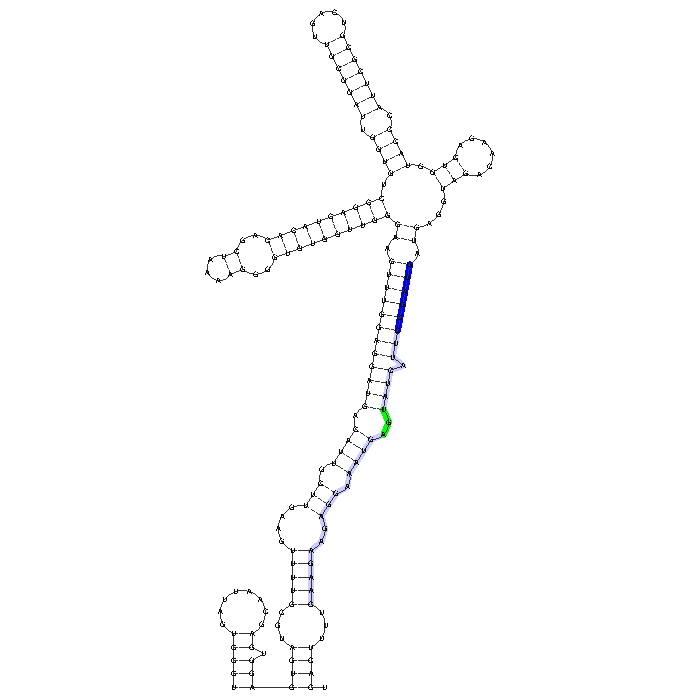

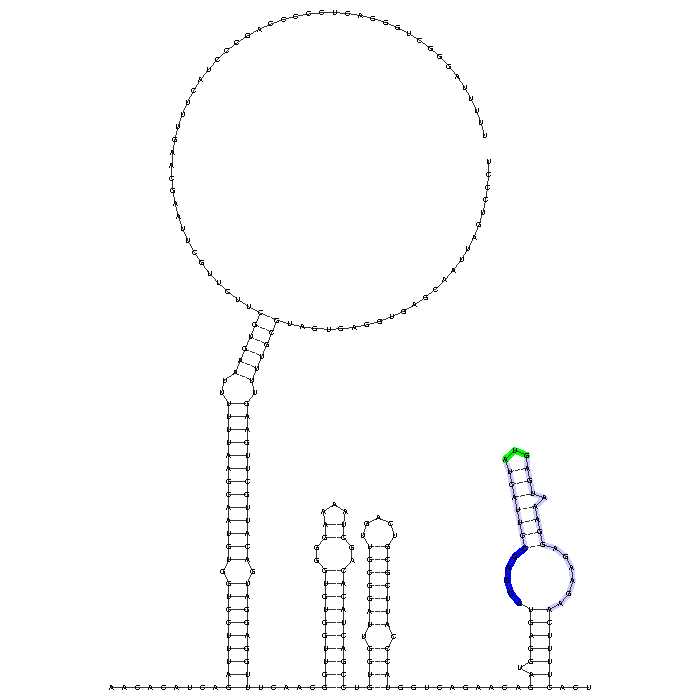

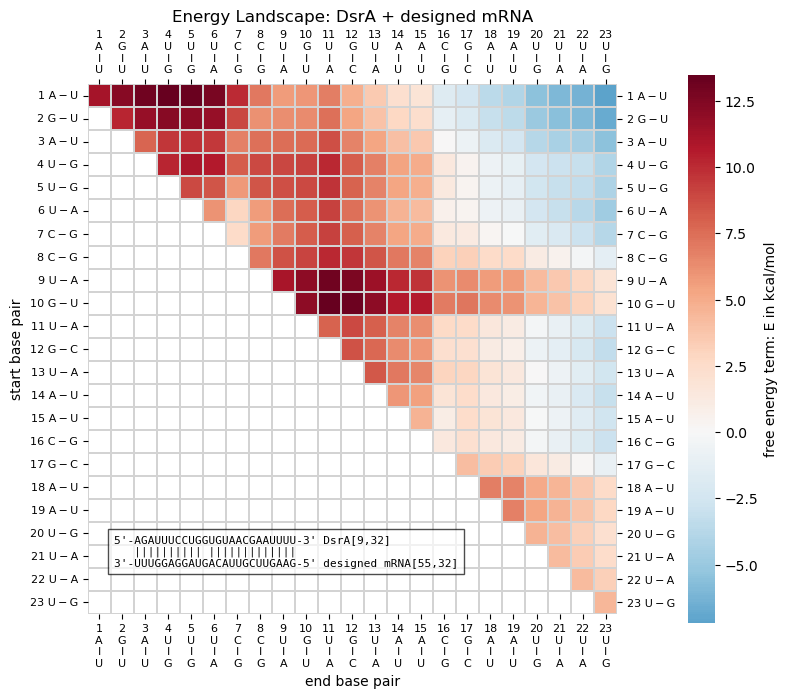

In [23]:
bestval_design = cost_dG(sRNA_design, mRNA_design)

print("Best design")
print('sRNA:', sRNA_design)
print('mRNA:', mRNA_design)
print('Cost:', bestval_design)
i, j, k, l, be = rri.RNAup(mRNA_design, sRNA_design)
print(i, j)
open = rri.dGopen(mRNA_design, (rri.PARAMS['SD_pos'], rri.PARAMS['SD_pos']+29))
open_b = rri.dGopen(mRNA_design, (rri.PARAMS['SD_pos'], rri.PARAMS['SD_pos']+29), constraint=(i, j))
print('Binding energy: {:6.2f}.  RBS opening energy unbound {:6.2f}, bound {:6.2f} kcal/mol'.format(be, open, open_b))

mRNA_unbound, sRNA_unbound = rri.prediction_unbound(mRNA_design, sRNA_design)
rri.draw_RNAplot_mRNA(mRNA_design, mRNA_unbound, output='unbound_thermodynamic_design.ps')
mRNA_bound, sRNA_bound = rri.prediction_bound(mRNA_design, sRNA_design)
rri.draw_RNAplot(sRNA_design, mRNA_design, sRNA_bound, mRNA_bound, output='bound_thermodynamic_design.ps')

rri.plot_energylandscape(sRNA_design, mRNA_design, id1='DsrA', id2="designed mRNA", figure_path="thermodynamic_design_landscape.pdf")


## Extending the cost function to kinetic features

In addition to the terms in the previouse cost function, we include
- a low free energy of the barrier state along the best folding path and
- and a stable seed interaction as start of the best folding path

The targeted energies are provided through the following agruments:
- binding energy: t_bind=-13 (in kcal/mol; maximum)
- opening energy of the RBS in the bound state: t_dG_bound=6 (in kcal/mol; maximum)
- opening energy of the RBS in the unbound mRNA: t_dG_free=11 (in kcal/mol; minimum)
- additional optimization weight on the difference between the bound and free RNS opening energy: target_t_dG_diff=True, 
- free (binding) energy of the barrier state: t_barrier=-1 (in kcal/mol; maximum)
- free energy of the seed interaction: t_seed=-1 (in kcal/mol; maximum)
  
Good designs are usually reaches within 1000 iterations (<10min on current laptop cpu), but shorter runs can alread get close to the targeted feature values. 


In [24]:
def cost_kinetics(
    sRNA,
    mRNA,
    region=(rri.PARAMS["SD_pos"], rri.PARAMS["SD_pos"] + 29),
    t_bind=-13,
    t_dG_bound=6,
    t_dG_free=11,
    target_t_dG_diff=True, 
    t_barrier=-1,
    t_seed=-1,
    verbose=False,
    vverbose=False,
):
    # predict best interaction structure
    intarna_args = (
        rri.gen_intarna_args()
    )  # + [ '--qRegion', f'1-{rri.PARAMS["SD_pos"]}']
    df = rri.run_intarna(
        sRNA, mRNA, id1="sRNA", id2="mRNA", temperature=37.0, intarna_args=intarna_args
    )
    mfe_interaction = df.to_dict(orient="records")[0]

    # compute kinetic features of best interaction structure
    bp_list = rri.intarna_to_bplist(mfe_interaction["bpList"], zero_based=True)
    max_j = max([bp[1] for bp in bp_list])
    
    if not max_j < region[0]:
        return 99
    seed_length = 5
    if len(bp_list) < seed_length:
        return 99

    
    el = rri.EnergyLandscape(sRNA, mRNA, bp_list)
    min_barrier_energies = el.get_min_barrier_Es(seed_length)
    seed_stabilities = el.get_seed_Es(seed_length)

    min_barrier = min(min_barrier_energies)
    seed_stability_min_barrier = seed_stabilities[
        min_barrier_energies.index(min_barrier)
    ]
    rrikindp_full_E = el.get_full_E() # from RRIkinDP
    interactionE = mfe_interaction["E"] # from IntaRNA

    # compute opening energies for RBS in unbound state:
    open_free = rri.dGopen(mRNA, region)
    
    # compute opening energies for RBS in unbound state:
    open_bound = rri.dGopen(
        mRNA, region, [int(mfe_interaction["start2"]), int(mfe_interaction["end2"])]
    )

    # difference between targeted opening energies
    t_dG_diff=t_dG_bound-t_dG_free


    # weight features in cost function
    bind, dG_bound, dG_free, dG_diff, seed, barrier = (
        (rrikindp_full_E  - t_bind) / 3,
        (open_bound - t_dG_bound) / 1,
        (t_dG_free-open_free) / 1,
        2*(open_bound - open_free - t_dG_diff) , 
        (seed_stability_min_barrier - t_seed) / 3,
        (min_barrier - t_barrier) / 1,
    )


    # compute cost
    if target_t_dG_diff:
        cost = LogSumExp(bind, dG_bound, dG_free, seed, barrier)
    else:
        cost = LogSumExp(bind, dG_bound, dG_free, dG_diff, seed, barrier)

    # output features
    if verbose:
        print("========================next design==================================")
        print("bind, dG_bound, dG_free, dG_diff, seed, barrier")
        print(
            "{:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f} {}".format(
               bind, dG_bound, dG_free, dG_diff, seed, barrier, 'weighted difference from target energies'
            )
        )
        print(
            "{:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f} {}".format(
                rrikindp_full_E,
                open_bound,
                open_free,
                open_bound - open_free,
                seed_stability_min_barrier,
                min_barrier,
                'energies'
            )
        )
        print(f'cost score: {cost}')
    if vverbose:
        print("designed mRNA")
        print(mRNA)
        
        print(f"The overall cost score is {cost}, it is computed from the following features (target energies in brackets):")
        print(f"- free energy of the full interaction: {rrikindp_full_E} kcal/mol ({t_bind} kcal/mol)")
        print(f"- free energy of the barrier state: {min_barrier} kcal/mol ({t_barrier} kcal/mol)")
        print(f"- free energy of {seed_length}bps seed from which the minimum barrier folding paths starts: {seed_stability_min_barrier} kcal/mol ({t_seed} kcal/mol)")
        print(f"- seed resulting in the minimum barrier state folding path starts at base pair {min_barrier_energies.index(min_barrier)+1}")
        print(f"- opening energy of the RBS+30nts when sRNA is bound: {open_bound} kcal/mol ({t_dG_bound} kcal/mol)")
        print(f"- opening energy of the RBS+30nts when mRNA is free: {open_free} kcal/mol ({t_dG_free} kcal/mol)")
        print(f"- change of the opening energy of the RBS+30nts when sRNA binds: {open_bound - open_free} kcal/mol ({t_dG_diff} kcal/mol; currently not targeted)")

        print('')
        print(f"IntaRNA results:")
        print(f"The interaction range on the sRNA is {mfe_interaction['start1']}-{mfe_interaction['end1']}")
        print(f"The interaction range on the mRNA is {mfe_interaction['start2']}-{mfe_interaction['end2']}")
        print(f"Base pair list: {mfe_interaction['bpList']}")
        #print(f'interaction in db notation: {mfe_interaction["hybridDPfull"]}')
        print(f'E: {mfe_interaction["E"]}, ED1: {mfe_interaction["ED1"]}, ED2: {mfe_interaction["ED2"]}, E_loops: {mfe_interaction["E_loops"]}')
        '''
        print('')
        print('dG_open based on interaction prediction from RNAup:')
        print(f"RBS acessibility:\n free mRNA:{open_free}; bound:{open_bound }; difference:{open_bound - open_free}")
        i, j, k, l, be = rri.RNAup(mRNA, sRNA)
        print("RNAup prediction for comparision")
        print("Binding region of rpos:", (i, j))
        print("Binding region of rdsa:", (k, l))
        print("Binding Energy:", be, "kcal/mol")
        '''
    return cost

### Generate design with kinetic cost function

In [25]:
start= time.time()

sRNA_kinetic, mRNA_kinetic, bestval_kinetic = run_optimize(1, model_rri, cost_kinetics, optimize=sa_optimize, EI=-15, EM=-7, verbose=True, steps=1000)
end = time.time()
print(f'run time in s: {end - start}')
print(f'run time in min: {(end - start)/60}')

# for accepted designs the sequence is printed

AACACAUCAGAUUUCCUGGUGUAACGAAUUUUUUAAGUGCUUCUUGCUUAAGCAAGUUUCAUCCCGACCCCCUCAGGGUCGGGAUUUUU GUCUCGUUUGUAUGCCUUCUCGCUGUGUUUGGAAGUUUGUUGCGAUAGGGAGUCUUUUGUAUCGUUAGAUUUGUUCGUACAGCAAAGGGGCCAAUUAACCUCAGAAAUUCCAUGCUGUGACUGCUGGAUCAGAGAGGCAGGAGCCAUGUCAUGAGUAAAGGAGAAGAACUUUUCACU 5.464694481511163
========================next design==================================
bind, dG_bound, dG_free, dG_diff, seed, barrier
  2.34   2.66   3.72  12.76   1.36   5.14 weighted difference from target energies
 -5.98   8.66   7.28   1.38   3.09   4.14 energies
cost score: 5.483529647652122
========================next design==================================
bind, dG_bound, dG_free, dG_diff, seed, barrier
  2.70   4.02   0.30   8.64   1.36   5.14 weighted difference from target energies
 -4.90  10.02  10.70  -0.68   3.09   4.14 energies
cost score: 5.506655390453058
========================next design==================================
bind, dG_bound, dG_free, dG_diff, seed, barrier
  2.20   4.07   0.46   9.04  -0.

Best design
sRNA: AACACAUCAGAUUUCCUGGUGUAACGAAUUUUUUAAGUGCUUCUUGCUUAAGCAAGUUUCAUCCCGACCCCCUCAGGGUCGGGAUUUUU
mRNA: AUGUUAGACUACUGUUUGGCGGCCGUAUUUAAAGAUUUGUUACGCUGGGGAAUCGCGCUCGUUCGCAGCCAGCCGUAGAAAAGGCGAGUUCCGCUCCCGUAGUUCUACGCGUUCCGGUUAGGUAAGGGCGAGCGUGAUAGGAGCCCCGGUAUGAGUAAAGGAGAAGAACUUUUCACU
Cost: 1.4458152091350438
========================next design==================================
bind, dG_bound, dG_free, dG_diff, seed, barrier
  0.52  -0.71  -1.14  -3.71  -0.07  -0.20 weighted difference from target energies
-11.44   5.29  12.14  -6.86  -1.20  -1.20 energies
cost score: 1.4458152091350438
designed mRNA
AUGUUAGACUACUGUUUGGCGGCCGUAUUUAAAGAUUUGUUACGCUGGGGAAUCGCGCUCGUUCGCAGCCAGCCGUAGAAAAGGCGAGUUCCGCUCCCGUAGUUCUACGCGUUCCGGUUAGGUAAGGGCGAGCGUGAUAGGAGCCCCGGUAUGAGUAAAGGAGAAGAACUUUUCACU
The overall cost score is 1.4458152091350438, it is computed from the following features (target energies in brackets):
- free energy of the full interaction: -11.44 kcal/mol (-13 kcal/mol)
- free energy of t

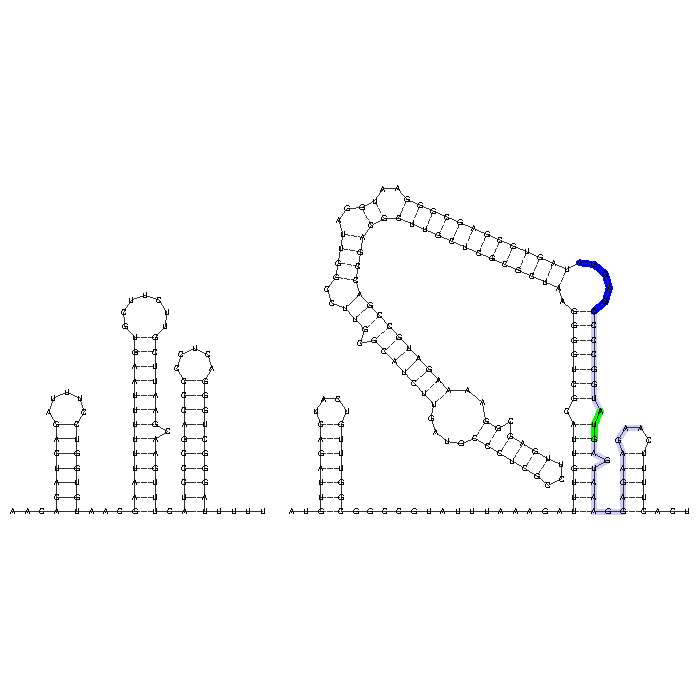

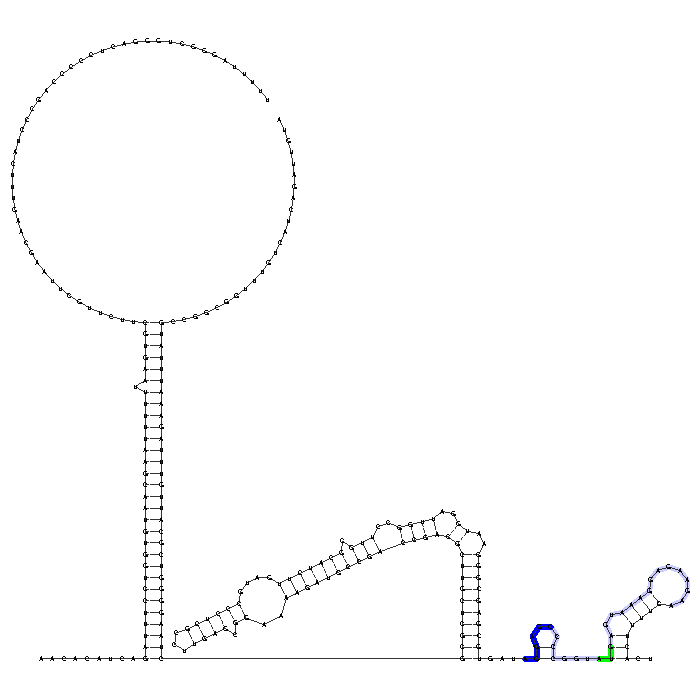

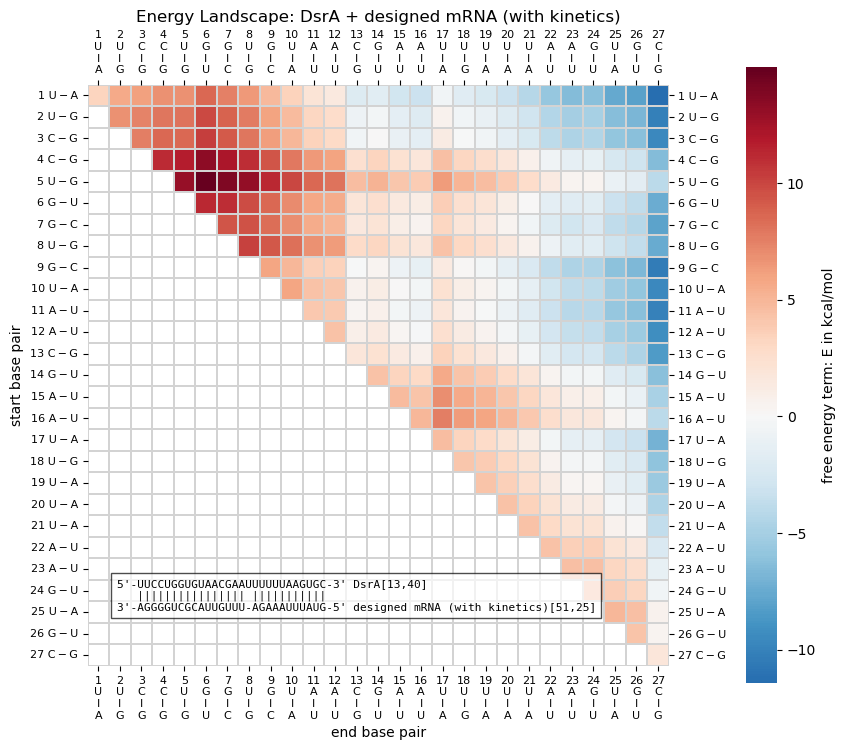

In [26]:
print("Best design")
print('sRNA:', sRNA_kinetic)
print('mRNA:', mRNA_kinetic)
print('Cost:', bestval_kinetic)

cost_kinetics(sRNA_kinetic, mRNA_kinetic, verbose =True, vverbose =True)

'''
i, j, k, l, be = rri.RNAup(mRNA_kinetic, sRNA_kinetic)
print("Interaction prediction with RNAup for comaprison")
print("Binding region of rpos:", (i, j))
print("Binding region of rdsa:", (k, l))
print("Binding Energy:", be, "kcal/mol")
'''

mRNA_unbound, sRNA_unbound = rri.prediction_unbound(mRNA_kinetic, sRNA_kinetic)
rri.draw_RNAplot(sRNA_kinetic, mRNA_kinetic, sRNA_unbound, mRNA_unbound,output='unbound_kinetic_design.ps')
mRNA_bound, sRNA_bound = rri.prediction_bound(mRNA_kinetic, sRNA_kinetic)
rri.draw_RNAplot(sRNA_kinetic, mRNA_kinetic, sRNA_bound, mRNA_bound, output='bound_kinetic_design.ps')

rri.plot_energylandscape(sRNA_kinetic, mRNA_kinetic, id1='DsrA', id2="designed mRNA (with kinetics)")


### Kinetic cost function applied to rpoS-DsrA example and thermodynamic design for comparison

In [27]:
cost_kinetics(dsra_seq, rpos_seq, verbose=False, vverbose=True)


designed mRNA
CACCGGAACCAGUUCAACACGCUUGCAUUUUGAAAUUCGUUACAAGGGGAAAUCCGUAAACCCGCUGCGUUAUUUGCCGCAGCGAUAAAUCGGCGGAACCAGGCUUUUGCUUGAAUGUUCCGUCAAGGGAUCACGGGUAGGAGCCACCUUAUGAGUCAGAAUACGCUGAAAGUUCAU
The overall cost score is 2.3847826956863036, it is computed from the following features (target energies in brackets):
- free energy of the full interaction: -11.69 kcal/mol (-13 kcal/mol)
- free energy of the barrier state: 0.68 kcal/mol (-1 kcal/mol)
- free energy of 5bps seed from which the minimum barrier folding paths starts: 0.68 kcal/mol (-1 kcal/mol)
- seed resulting in the minimum barrier state folding path starts at base pair 12
- opening energy of the RBS+30nts when sRNA is bound: 6.337974548339844 kcal/mol (6 kcal/mol)
- opening energy of the RBS+30nts when mRNA is free: 11.234672546386719 kcal/mol (11 kcal/mol)
- change of the opening energy of the RBS+30nts when sRNA binds: -4.896697998046875 kcal/mol (-5 kcal/mol; currently not targeted)

IntaRNA results:
The interaction range on t

2.3847826956863036

In [29]:
cost_kinetics(sRNA_design, mRNA_design, verbose=False, vverbose=True)


designed mRNA
UCCCUGAUUAACGAGUGGAGUGAUGCGUUUUGAAGUUCGUUACAGUAGGAGGUUUCAACGGUUGGUGUGGGGAAAAUCGACACAUCAGCCUGUGGUUAGGCGUUGACUGCGCUUACCCAUGGUCAGAACAGAUGGAGUAGGAGCCUUACUAUGAGUAAAGGAGAAGAACUUUUCACU
The overall cost score is 3.798430123588564, it is computed from the following features (target energies in brackets):
- free energy of the full interaction: -7.2 kcal/mol (-13 kcal/mol)
- free energy of the barrier state: 2.07 kcal/mol (-1 kcal/mol)
- free energy of 5bps seed from which the minimum barrier folding paths starts: 1.39 kcal/mol (-1 kcal/mol)
- seed resulting in the minimum barrier state folding path starts at base pair 14
- opening energy of the RBS+30nts when sRNA is bound: 8.635135650634766 kcal/mol (6 kcal/mol)
- opening energy of the RBS+30nts when mRNA is free: 15.319305419921875 kcal/mol (11 kcal/mol)
- change of the opening energy of the RBS+30nts when sRNA binds: -6.684169769287109 kcal/mol (-5 kcal/mol; currently not targeted)

IntaRNA results:
The interaction range on the 

3.798430123588564